<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Image_classification_via_fine_tuning_with_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
model = EfficientNetB0(weights='imagenet')

21839872/21834768 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
model_1 = EfficientNetB0(include_top=False, weights='imagenet')

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
model_1.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [ ]:
from cloud_tpu_client import Client
c = Client()
c.configure_tpu_version(tf.__version__, restart_type="always")

ModuleNotFoundError: ignored

In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteNZBD32/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteNZBD32/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

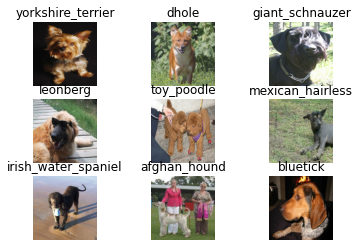

In [ ]:
import matplotlib.pyplot as plt

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features['label']
for i , (image, label) in enumerate(ds_train.take(9)):
  ax = plt.subplot(3, 3, i +1)
  plt.imshow(image.numpy().astype('uint8'))
  plt.title('{}'.format(format_label(label)))
  plt.axis('off')

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


img_augmentation = Sequential([
                               preprocessing.RandomRotation(factor=0.15),
                               preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
                               preprocessing.RandomFlip(),
                               preprocessing.RandomContrast(factor=0.1)
], name = 'img_augmentation')

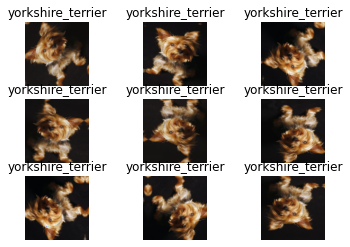

In [ ]:
for image, label in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    aug_img = img_augmentation(tf.expand_dims(image, axis=0))
    plt.imshow(aug_img[0].numpy().astype('uint8'))
    plt.title("{}".format(format_label(label)))
    plt.axis('off')

In [ ]:
# One-hot / categorical encoding

def input_preprocess(image, label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

ds_train = ds_train.map(input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = img_augmentation(inputs)
  outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

epochs= 40
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 120)               4203291   
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/40
187/187 - 164s - loss: 4.9647 - accuracy: 0.0112 - val_loss: 5.0181 - val_accuracy: 0.0061
Epoch 2/40


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
  plt.plot(hist.history["accuracy"])
  plt.plot(hist.history["val_accuracy"])
  plt.title("model accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()


plot_hist(hist)

NameError: ignored

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

def build_model(num_classes):
  inputs = layers.Input(shape =(IMG_SIZE, IMG_SIZE, 3))
  x = img_augmentation(inputs)
  model = EfficientNetB0(include_top=False, input_tensor=x, weights='imagenet')

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name = 'avg_pool')(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate= 0.2
  x = layers.Dropout(top_dropout_rate, name = 'top_dropout')(x)
  outputs = layers.Dense(num_classes, activation='softmax', name = 'pred')(x)

  #Compile
  model = tf.keras.Model(inputs, outputs, name = 'EfficientNet')
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model 


In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 21  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

Epoch 1/21
187/187 - 46s - loss: 3.5276 - accuracy: 0.3758 - val_loss: 0.9818 - val_accuracy: 0.7109
Epoch 2/21
187/187 - 36s - loss: 1.8556 - accuracy: 0.5274 - val_loss: 0.8376 - val_accuracy: 0.7399
Epoch 3/21
187/187 - 37s - loss: 1.5604 - accuracy: 0.5740 - val_loss: 0.7866 - val_accuracy: 0.7578
Epoch 4/21
187/187 - 37s - loss: 1.4527 - accuracy: 0.5867 - val_loss: 0.7737 - val_accuracy: 0.7629
Epoch 5/21
187/187 - 37s - loss: 1.3771 - accuracy: 0.6131 - val_loss: 0.7857 - val_accuracy: 0.7621
Epoch 6/21
187/187 - 37s - loss: 1.3513 - accuracy: 0.6175 - val_loss: 0.7692 - val_accuracy: 0.7692
Epoch 7/21
187/187 - 37s - loss: 1.3165 - accuracy: 0.6258 - val_loss: 0.7959 - val_accuracy: 0.7652
Epoch 8/21


KeyboardInterrupt: ignored

Epoch 1/10
187/187 - 48s - loss: 1.0509 - accuracy: 0.6920 - val_loss: 0.6713 - val_accuracy: 0.7947
Epoch 2/10
187/187 - 39s - loss: 0.9312 - accuracy: 0.7243 - val_loss: 0.6667 - val_accuracy: 0.7985
Epoch 3/10
187/187 - 38s - loss: 0.8669 - accuracy: 0.7391 - val_loss: 0.6703 - val_accuracy: 0.7983
Epoch 4/10
187/187 - 39s - loss: 0.7974 - accuracy: 0.7581 - val_loss: 0.6609 - val_accuracy: 0.7998
Epoch 5/10
187/187 - 39s - loss: 0.7637 - accuracy: 0.7690 - val_loss: 0.6661 - val_accuracy: 0.7978
Epoch 6/10
187/187 - 39s - loss: 0.7220 - accuracy: 0.7797 - val_loss: 0.6696 - val_accuracy: 0.7954
Epoch 7/10
187/187 - 39s - loss: 0.6804 - accuracy: 0.7928 - val_loss: 0.6779 - val_accuracy: 0.7956
Epoch 8/10
187/187 - 40s - loss: 0.6550 - accuracy: 0.8016 - val_loss: 0.6707 - val_accuracy: 0.7966
Epoch 9/10
187/187 - 39s - loss: 0.6246 - accuracy: 0.8089 - val_loss: 0.6789 - val_accuracy: 0.7955
Epoch 10/10
187/187 - 39s - loss: 0.5997 - accuracy: 0.8176 - val_loss: 0.6895 - val_accura

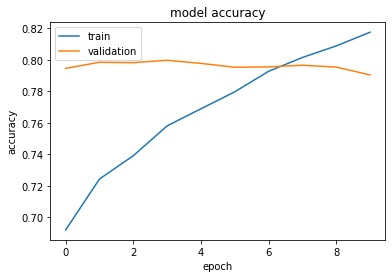

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )



unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

In [ ]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet\
       /noisystudent/noisy_student_efficientnet-b1.tar.gz
!tar -xf noisy_student_efficientnet-b1.tar.gz

--2021-05-28 03:31:39--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-05-28 03:31:39 ERROR 404: Not Found.

/noisystudent/noisy_student_efficientnet-b1.tar.gz: Scheme missing.
tar: noisy_student_efficientnet-b1.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
!python efficientnet_weight_update_util.py --model b1 --notop --ckpt \
        efficientnet-b1/model.ckpt --o efficientnetb1_notop.h5

python3: can't open file 'efficientnet_weight_update_util.py': [Errno 2] No such file or directory


In [ ]:
from tensorflow.keras.applications import EfficientNetB1

model = EfficientNetB1(weights="efficientnetb1_notop.h5", include_top=False)

ValueError: ignored

Epoch 1/10
187/187 - 39s - loss: 0.5705 - accuracy: 0.8271 - val_loss: 0.6863 - val_accuracy: 0.7916
Epoch 2/10
187/187 - 39s - loss: 0.5479 - accuracy: 0.8326 - val_loss: 0.7074 - val_accuracy: 0.7893
Epoch 3/10
187/187 - 38s - loss: 0.5387 - accuracy: 0.8354 - val_loss: 0.7019 - val_accuracy: 0.7896
Epoch 4/10
187/187 - 39s - loss: 0.4989 - accuracy: 0.8446 - val_loss: 0.7062 - val_accuracy: 0.7873
Epoch 5/10
187/187 - 38s - loss: 0.4838 - accuracy: 0.8538 - val_loss: 0.7043 - val_accuracy: 0.7886
Epoch 6/10
187/187 - 39s - loss: 0.4728 - accuracy: 0.8531 - val_loss: 0.7097 - val_accuracy: 0.7842
Epoch 7/10
187/187 - 39s - loss: 0.4539 - accuracy: 0.8661 - val_loss: 0.7167 - val_accuracy: 0.7856
Epoch 8/10
187/187 - 40s - loss: 0.4255 - accuracy: 0.8704 - val_loss: 0.7210 - val_accuracy: 0.7851
Epoch 9/10
187/187 - 39s - loss: 0.4113 - accuracy: 0.8764 - val_loss: 0.7257 - val_accuracy: 0.7832
Epoch 10/10
187/187 - 39s - loss: 0.3886 - accuracy: 0.8834 - val_loss: 0.7290 - val_accura

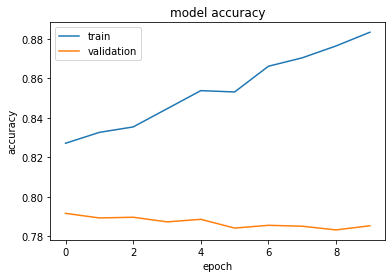

In [ ]:
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)